### One of the Main Strengths in Julia is its Convenience in Implementing CPU Parallel Computing. Below Check First the Number of Threads Being Used

In [15]:
#The number of threads being used is set in the enviromental variables in Windows system (ask chatgpt for further details). 
#My computer has 8 CPU cores and 16 LUs, so 8 threads are used here.
using Base.Threads
println("Number of Threads:",nthreads())

Number of Threads:8


In [16]:
print(Int64.(1:10))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### Generator Validity Verification

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


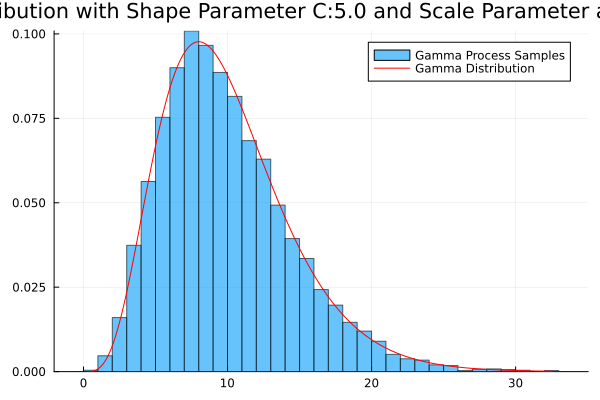

In [1]:
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter
N = 10000 # 样本数量
T = 1.0 # 模拟时间
beta = 0.5 # 逆比例参数
alpha = 1.0 / beta # 生成时的比例参数
C = 5.0 # 速率/形状参数
samples = Float64[]

@showprogress for i in 1:N
    samples_matrix, jump_time_matrix = Julia_Implementation.vectorized_particle_Gamma_generator(beta, C, T, 1, 1, 100)
    gamma_jumps = samples_matrix[1, :]
    gamma_jump_times = jump_time_matrix[1, :]
    sample = Julia_Implementation.integrate([1.0], gamma_jumps, gamma_jump_times)
    push!(samples, sample[1])
end

# 定义x的范围，以匹配samples的范围或更广
x = range(minimum(samples), stop=maximum(samples), length=1000)

p = histogram(samples, bins=50, normalize=true, alpha=0.6, label="Gamma Process Samples")
plot!(p, x, pdf.(Gamma(C, alpha), x), color=:red, label="Gamma Distribution")
title!(p, "Gamma Distribution with Shape Parameter C:$(C) and Scale Parameter alpha (1/beta):$(alpha)")
#legend!(:topright) # 如果需要图例，取消这行注释
display(p)


In [12]:
x = [1 2 3 4 5 6 7 8 9; 1 2 3 4 5 6 7 8 9]
y = reshape(sum(reshape(x', 3, 2, 3), dims=1),3,2)'

2×3 adjoint(::Matrix{Int64}) with eltype Int64:
 6  15  24
 6  15  24

In [1]:
println(typeof([1 1; 1 1]))

Matrix{Int64}


### SDE Samples and Samples Masked with Noise

[1.0 0.0012822307655711018; 0.0 0.9974355384688578]
[1.0 0.011167290780496275; 0.0 0.9776654184390074]
[1.0 0.008904603320024962; 0.0 0.9821907933599501]
[1.0 0.02085641951419065; 0.0 0.9582871609716187]
[1.0 0.018638580668951354; 0.0 0.9627228386620973]
[1.0 0.030353500510801323; 0.0 0.9392929989783974]
[1.0 0.02817962133862978; 0.0 0.9436407573227404]
[1.0 0.03966234033894067; 0.0 0.9206753193221187]
[1.0 0.037531549517350826; 0.0 0.9249369009652983]
[1.0 0.048786670117414555; 0.0 0.9024266597651709]
[1.0 0.04669811359435999; 0.0 0.90660377281128]
[1.0 0.057730147010709276; 0.0 0.8845397059785814]
[1.0 0.05568298766226637; 0.0 0.8886340246754673]
[1.0 0.06649635569483625; 0.0 0.8670072886103275]
[1.0 0.06448977298967301; 0.0 0.871020454020654]
[1.0 0.07508880979412258; 0.0 0.8498223804117548]
[1.0 0.07312199946461767; 0.0 0.8537560010707647]
[1.0 0.08351095328952307; 0.0 0.8329780934209539]
[1.0 0.0815831270094034; 0.0 0.8368337459811932]
[1.0 0.09176616189901776; 0.0 0.8164676762019

Excessive output truncated after 524298 bytes.


[1.0 0.48384832760647195; 0.0 0.03230334478705613]
[1.0 0.4981280546679538; 0.0 0.003743890664092379]
[1.0 0.4434344553240574; 0.0 0.11313108935188522]
[1.0 0.49780601615905706; 0.0 0.0043879676818858685]
[1.0 0.4999173399747156; 0.0 0.00016532005056876843]
[1.0 0.4996916058418969; 0.0 0.0006167883162061985]
[1.0 0.34503007704708644; 0.0 0.3099398459058272]
[1.0 0.477025498810039; 0.0 0.04594900237992209]
[1.0 0.48764906824015625; 0.0 0.02470186351968747]
[1.0 0.48721582965014537; 0.0 0.025568340699709226]
[1.0 0.49988188543945183; 0.0 0.00023622912109636418]
[1.0 0.4957682958614654; 0.0 0.008463408277069146]
[1.0 0.4155371814510237; 0.0 0.16892563709795258]
[1.0 0.4987569398013464; 0.0 0.0024861203973072397]
[1.0 0.4980236000039058; 0.0 0.0039527999921884676]
[1.0 0.4747891349504244; 0.0 0.05042173009915123]
[1.0 0.49736121656082216; 0.0 0.005277566878355705]
[1.0 0.49562961310892656; 0.0 0.008740773782146853]
[1.0 0.49977387803040596; 0.0 0.0004522439391881195]
[1.0 0.49873057548497

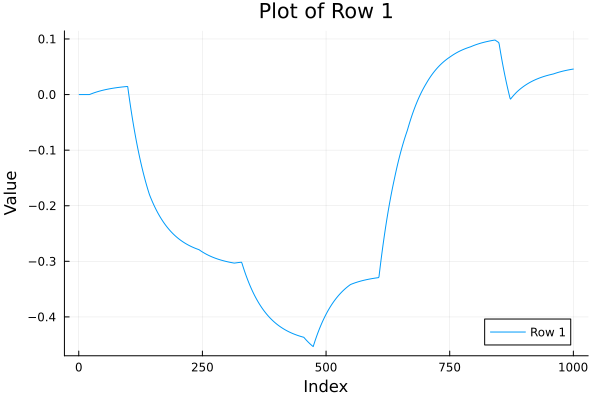

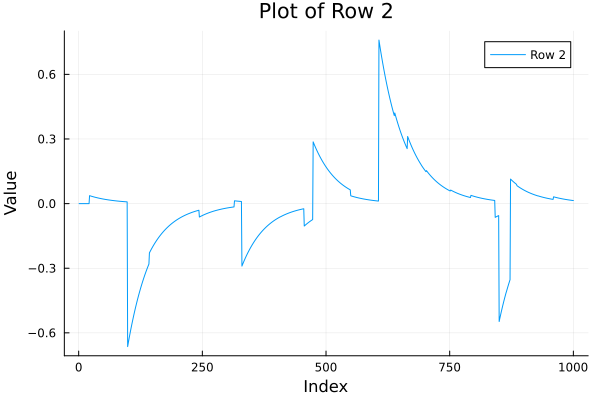

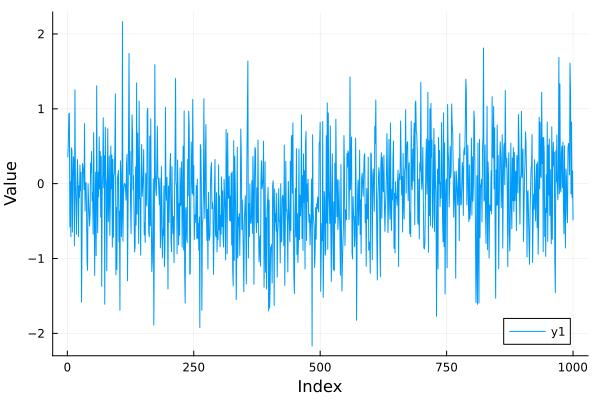

In [2]:
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter

# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 2.0 # beta的初始猜测
C0 = 0.1 # C的初始猜测
num_particles = 1000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -2.0
kw = 1.0
kv = 0.1
true_sigmaw = 2.0
true_muw = 0.0
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 0.1
T = 10.0
N = 100 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0, 1.0]
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")
subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 100)# subordinator jump sizes and times
samples = Julia_Implementation.generate_SDE_samples(subordinator_jumps[1,:],jump_times[1,:],true_muw,true_sigmaw,A,h,evaluation_points)
#print(size(samples))
# 分开绘制每一行
for i in 1:size(samples, 1)
    plot(samples[i, :], label=string("Row ", i))
    title!("Plot of Row $i")
    xlabel!("Index")
    ylabel!("Value")
    display(plot!()) # 使用 display 来显示图表
end

# 生成噪声观测数据
Noisy_samples = samples[1, :] .+ randn(length(samples[1, :])) .* sigma_n

#print(size(Noisy_samples))
# 下一步是基于这些数据进行参数估计或其他分析，这部分代码取决于具体的分析目标
plot(Noisy_samples)
xlabel!("Index")
ylabel!("Value")
display(plot!())





In [3]:
println(A[2,2])

### Broadcasting Experiment. Broadcast元素是整个[]，关键看怎么定义[],非常灵活。 Julia在实际物件上是没有高维数组的定义的，只有1和2维不断叠加

In [29]:
# 定义矩阵 A 和 B
using Base.Threads
matrix_A = ones(2, 2)
matrix_B = [1 2; 3 4]  # 直接定义，简化创建过程

# 定义四维矩阵 C，每个元素是 2x2 矩阵，全部初始化为 1
matrix_C_2D = repeat(matrix_A,2,2)
println(matrix_C_2D) #注意结果仍然是个2D矩阵

matrix_C_desired = repeat([matrix_A],2,2) #此结果依旧是2D矩阵，但是每个元素也还是个2D的矩阵，超级方便好理解。之后直接elementwise运算应用，无敌方便

[1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]


2×2 Matrix{Matrix{Float64}}:
 [1.0 1.0; 1.0 1.0]  [1.0 1.0; 1.0 1.0]
 [1.0 1.0; 1.0 1.0]  [1.0 1.0; 1.0 1.0]

In [32]:
#Scalar Compatible!!!!
size(1,1)
size(1,2)

1

In [2]:
#The Problem of Common Reference
mat1 = [1 2; 3 4]
array_of_matrices = repeat([mat1], 2, 2)
array_of_matrices[1, 1][1, 1] = 99
println(array_of_matrices)


[[99 2; 3 4] [99 2; 3 4]; [99 2; 3 4] [99 2; 3 4]]


In [1]:
# 定义矩阵 A 和 B
using Base.Threads
matrix_A = ones(2, 2)
matrix_B = [1 2; 3 4]  # 直接定义，简化创建过程

# 定义四维矩阵 C，每个元素是 2x2 矩阵，全部初始化为 1
matrix_C = ones(2, 2, 2000, 2000)  # 这里简化了初始化过程，实际可以按需要赋值
result_elementwise = matrix_C .* matrix_B #关键是进去之后还是点乘而非矩阵乘法
#println(result_elementwise)


# 初始化结果数组，保持与 matrix_C 相同的四维结构
result_matrix_mult = similar(matrix_C)

# 执行矩阵乘法
@threads for i in 1:size(matrix_C, 3)
    @threads for j in 1:size(matrix_C, 4)
        result_matrix_mult[:, :, i, j] = matrix_B * matrix_C[:, :, i, j]  #想要非点乘的矩阵乘法只能用for loop
    end
end

# 输出结果，查看四维数组中的矩阵乘法结果
#println(result_matrix_mult)

In [9]:
matrix_A = ones(2, 2)
matrix_B = [1 2; 3 4]  # 直接定义，简化创建过程

# 定义四维矩阵 C，每个元素是 2x2 矩阵，全部初始化为 1
matrix_C = ones(size(matrix_B,1),size(matrix_B,2),2000,2000)  # 这里简化了初始化过程，实际可以按需要赋值
result_elementwise = matrix_C .* matrix_B #关键是进去之后还是点乘而非矩阵乘法

2×2×2000×2000 Array{Float64, 4}:
[:, :, 1, 1] =
 1.0  2.0
 3.0  4.0

[:, :, 2, 1] =
 1.0  2.0
 3.0  4.0

[:, :, 3, 1] =
 1.0  2.0
 3.0  4.0

;;; … 

[:, :, 1998, 1] =
 1.0  2.0
 3.0  4.0

[:, :, 1999, 1] =
 1.0  2.0
 3.0  4.0

[:, :, 2000, 1] =
 1.0  2.0
 3.0  4.0

[:, :, 1, 2] =
 1.0  2.0
 3.0  4.0

[:, :, 2, 2] =
 1.0  2.0
 3.0  4.0

[:, :, 3, 2] =
 1.0  2.0
 3.0  4.0

;;; … 

[:, :, 1998, 2] =
 1.0  2.0
 3.0  4.0

[:, :, 1999, 2] =
 1.0  2.0
 3.0  4.0

[:, :, 2000, 2] =
 1.0  2.0
 3.0  4.0

[:, :, 1, 3] =
 1.0  2.0
 3.0  4.0

[:, :, 2, 3] =
 1.0  2.0
 3.0  4.0

[:, :, 3, 3] =
 1.0  2.0
 3.0  4.0

;;; … 

[:, :, 1998, 3] =
 1.0  2.0
 3.0  4.0

[:, :, 1999, 3] =
 1.0  2.0
 3.0  4.0

[:, :, 2000, 3] =
 1.0  2.0
 3.0  4.0

;;;; … 

[:, :, 1, 1998] =
 1.0  2.0
 3.0  4.0

[:, :, 2, 1998] =
 1.0  2.0
 3.0  4.0

[:, :, 3, 1998] =
 1.0  2.0
 3.0  4.0

;;; … 

[:, :, 1998, 1998] =
 1.0  2.0
 3.0  4.0

[:, :, 1999, 1998] =
 1.0  2.0
 3.0  4.0

[:, :, 2000, 1998] =
 1.0  2.0
 3.0  4.0

[:, :, 1

In [1]:
include("Julia_Implementation.jl")
N = 1000 #
T = 100 # 模拟时间
beta = 0.5 # 逆比例参数
alpha = 1 / beta # 生成时的比例参数
C = 5 # 速率/形状参数
Julia_Implementation.vectorized_particle_Gamma_generator(beta, C, T, N, 1000, 100);

### Proposal Computations

In [17]:
include("Julia_Implementation.jl")
using Profile
# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 10000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -1.0
kw = 1.0
kv = 0.1
true_sigmaw = 0.2
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 2.0
T = 30.0
N = 10 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0, 1.0]
h = reshape(h, :, 1) 
#Pre-heat, note that pre-heat can decrease the time significantly
Julia_Implementation.vectorized_particle_transition_function(true_beta, true_C, T, N, 10, A, h ;c=10)


@profile mean_matrix, cov_matrix = Julia_Implementation.vectorized_particle_transition_function(true_beta, true_C, T, N, num_particles, A, h ;c=10)
println(size(mean_matrix))
println(size(cov_matrix))

Profile.print()


(10000, 300)
(10000, 300)


┌ Warning: The profile data buffer is full; profiling probably terminated
│ before your program finished. To profile for longer runs, call
│ `Profile.init()` with a larger buffer and/or larger delay.
└ @ Profile C:\Users\Bill\AppData\Local\Programs\Julia-1.9.3\share\julia\stdlib\v1.9\Profile\src\Profile.jl:639


Overhead ╎ [+additional indent] Count File:Line; Function
     ╎111117 @Base\client.jl:522; _start()
     ╎ 111117 @Base\client.jl:307; exec_options(opts::Base.JLOp...
     ╎  111117 @Base\Base.jl:457; include(mod::Module, _path::...
     ╎   111117 @Base\loading.jl:1963; _include(mapexpr::Function,...
     ╎    111117 @Base\loading.jl:1903; include_string(mapexpr::ty...
     ╎     111117 @Base\boot.jl:370; eval
     ╎    ╎ 111117 ...book\notebook.jl:35; top-level scope
     ╎    ╎  111117 ...erve_notebook.jl:75; kwcall(::NamedTuple{(:cra...
     ╎    ╎   111117 ...rve_notebook.jl:139; serve_notebook(pipename:...
     ╎    ╎    111117 ...PC\src\typed.jl:67; dispatch_msg(x::VSCodeSe...
     ╎    ╎     111117 ...rve_notebook.jl:13; notebook_runcell_request...
     ╎    ╎    ╎ 111117 ...er\src\repl.jl:274; withpath(f::VSCodeServ...
     ╎    ╎    ╎  111117 ...ve_notebook.jl:19; (::VSCodeServer.var"#2...
     ╎    ╎    ╎   111117 ...essentials.jl:816; invokelatest
     ╎    ╎    ╎    11111

Excessive output truncated after 524362 bytes.


     ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +17 1      ...reduce.jl:24; add_sum
     ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +18 1      ...aymath.jl:14; +(A::Matrix{Flo...
     ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +19 1      ...ndices.jl:169; promote_shape(a...
     ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +20 1      ...tarray.jl:98; axes
    1╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +21 1      ...\array.jl:150; size
     ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +11 2      ...reduce.jl:267; mapreduce_impl(...
     ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +12 1      ...reduce.jl:266; mapreduce_impl(...
     ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +13 1      ...reduce.jl:267; mapreduce_impl(...
     ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +14 1      ...reduce.jl:258; mapreduce_impl(...
     ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +15 1      ...mdloop.jl:77; macro expansion
     ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +16 1      ...reduce.jl:260; macro expansion
     ╎    ╎    ╎    ╎    ╎    ╎    ╎    ╎ +17 1      ...re

In [13]:
i = 1000
j=300
println(mean_matrix[i,j])
println(cov_matrix[i,j])


[0.08619424170405778; 0.9747532734342812;;]
[0.0070026530030270085 0.07919158870103075; 0.07919158870103075 0.8955616847332505]


In [19]:
using .Threads

In [1]:
include("Julia_Implementation.jl")
using Profile
# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 10000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -1.0
kw = 1.0
kv = 0.1
true_sigmaw = 0.2
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 2.0
T = 30.0
N = 10 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0, 1.0]
h = reshape(h, :, 1) 
#Pre-heat, note that pre-heat can decrease the time significantly
Julia_Implementation.vectorized_particle_transition_function(true_beta, true_C, T, N, 10, A, h ;c=10)

mean_matrix, cov_matrix = Julia_Implementation.vectorized_particle_transition_function(true_beta, true_C, T, N, num_particles, A, h ;c=10)
println(size(mean_matrix))
println(size(cov_matrix))



(10000, 300)
(10000, 300)


In [14]:
i = 6
j=200
println(mean_matrix[i,j])
println(cov_matrix[i,j])


[0.05518162956939906; 0.7912789092460507;;]
[0.003597346955116909 0.051584282614282155; 0.051584282614282155 0.7396946266317685]


### Marginalised Particle Filter

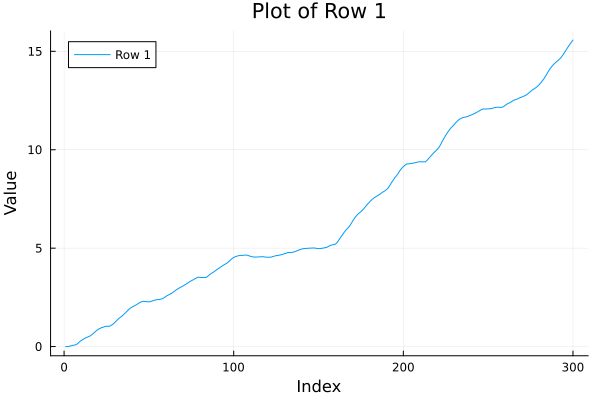

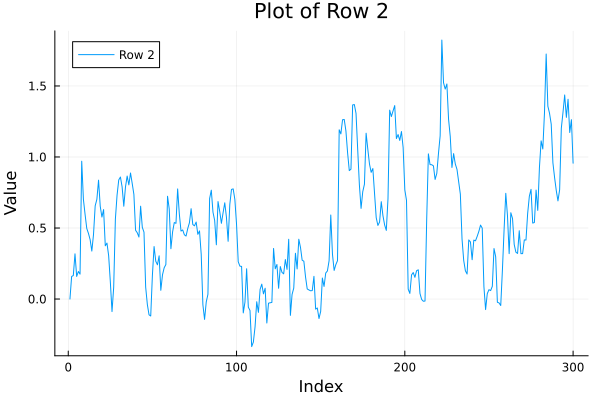

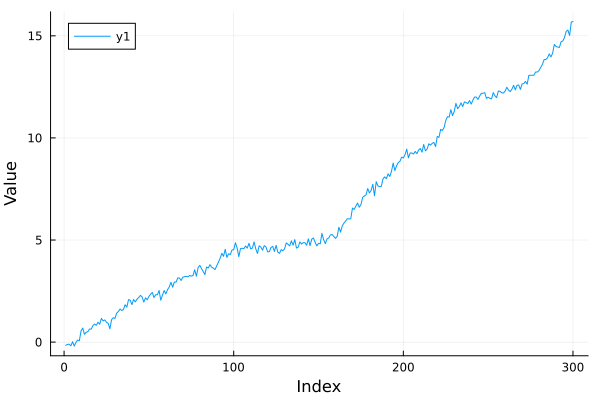

In [17]:
#Generation of Noisy Samples
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter

# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 1000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -1.0
kw = 1.0
kv = 0.1
true_sigmaw2 = 0.2
true_sigmaw = sqrt(true_sigmaw2)
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 10.0
T = 30.0
N = 10 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta

h = [0.0, 1.0]
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")
subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 1000)# subordinator jump sizes and times
samples = Julia_Implementation.generate_SDE_samples(subordinator_jumps[1,:],jump_times[1,:],true_muw,true_sigmaw,A,h,evaluation_points)
#print(size(samples))
# 分开绘制每一行
for i in 1:size(samples, 1)
    plot(samples[i, :], label=string("Row ", i))
    title!("Plot of Row $i")
    xlabel!("Index")
    ylabel!("Value")
    display(plot!()) # 使用 display 来显示图表
end

# 生成噪声观测数据
Noisy_samples = samples[1, :] .+ randn(length(samples[1, :])) .* sigma_n

#print(size(Noisy_samples))
# 下一步是基于这些数据进行参数估计或其他分析，这部分代码取决于具体的分析目标
plot(Noisy_samples)
xlabel!("Index")
ylabel!("Value")
display(plot!())





In [14]:
println(size(jump_times))
println(N)

(1, 100)
300


#### Assume that we have obtained the data as Noisy_samples and evaluation_points

In [1]:
include("Julia_Implementation.jl")
using Profile


# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 1000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -1.0
kw = 1.0
kv = 0.1
true_sigmaw = 0.2
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 2.0
T = 30.0
N = 10 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0, 1.0]
h = reshape(h, :, 1) 
#Pre-heat, note that pre-heat can decrease the time significantly
Julia_Implementation.vectorized_particle_transition_function(true_beta, true_C, T, N, 10, A, h ;c=10)
#The particle proposals
mean_matrix, cov_matrix = Julia_Implementation.vectorized_particle_transition_function(true_beta, true_C, T, N, num_particles, A, h ;c=10)






([[0.0; 0.0;;] [0.0; 0.0;;] … [0.0; 0.0;;] [0.029857709025768984; 0.8260558628921241;;]; [0.0; 0.0;;] [0.0; 0.0;;] … [0.0; 0.0;;] [0.0; 0.0;;]; … ; [0.0; 0.0;;] [0.0; 0.0;;] … [0.0; 0.0;;] [0.0; 0.0;;]; [0.0; 0.0;;] [0.0; 0.0;;] … [0.08360690320653326; 1.0724260555777654;;] [0.007964460497112694; 0.8982101186709947;;]], [[0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] … [0.0 0.0; 0.0 0.0] [0.0010415570187418475 0.028816152007027137; 0.028816152007027137 0.7972397108850969]; [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] … [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0]; … ; [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] … [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0]; [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] … [0.006046639250785316 0.07756026395574794; 0.07756026395574794 0.9948657916220174] [7.000045296823647e-5 0.007894460044144456; 0.007894460044144456 0.8903156586268502]])

In [4]:
mean_matrix, cov_matrix = Julia_Implementation.vectorized_particle_transition_function(true_beta, true_C, T, N, num_particles, A, h ;c=10)

([[0.0; 0.0;;] [0.0; 0.0;;] … [0.0; 0.0;;] [0.0; 0.0;;]; [0.0; 0.0;;] [0.0; 0.0;;] … [0.0; 0.0;;] [0.0; 0.0;;]; … ; [0.0; 0.0;;] [0.0; 0.0;;] … [0.0; 0.0;;] [0.0; 0.0;;]; [0.0; 0.0;;] [0.0; 0.0;;] … [0.0; 0.0;;] [0.0; 0.0;;]], [[0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] … [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0]; [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] … [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0]; … ; [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] … [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0]; [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0] … [0.0 0.0; 0.0 0.0] [0.0 0.0; 0.0 0.0]])

In [2]:
using Pkg
Pkg.add("Plots")
Pkg.add("Statistics")
Pkg.add("DataFrames")



   Resolving package versions...
  No Changes to `C:\Users\Bill\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Bill\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Bill\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Bill\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
   Installed InlineStrings ── v1.4.0
   Installed PooledArrays ─── v1.4.3
   Installed SentinelArrays ─ v1.4.1
   Installed DataFrames ───── v1.6.1
    Updating `C:\Users\Bill\.julia\environments\v1.9\Project.toml`
  [a93c6f00] + DataFrames v1.6.1
    Updating `C:\Users\Bill\.julia\environments\v1.9\Manifest.toml`
  [a93c6f00] + DataFrames v1.6.1
  [842dd82b] + InlineStrings v1.4.0
  [2dfb63ee] + PooledArrays v1.4.3
  [91c51154] + SentinelArrays v1.4.1
Precompiling project...
  ✓ PooledArrays
  ✓ InlineStrings
  ✓ SentinelArrays
  ✓ DataFrames
  ✓ Latexify → DataFramesExt
  ✓ BangBang → BangBangDataFramesExt
  ✓

In [19]:
using Random
using Distributions
using LinearAlgebra
using Statistics
using StatsFuns: logsumexp
using .Threads
using ProgressMeter
using SpecialFunctions
println(I-[0 0;0 0])
println(lgamma.([10 5 3]))
println(collect(range(0,1,10)))
println(dot([1,2,3],[1;2;3]))

[1 0; 0 1]
[12.80182748008147 3.1780538303479458 0.6931471805599453]
[0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777778, 0.8888888888888888, 1.0]
14


In [25]:
x = [1 1; 2 2]
X = [copy(x) for _ in 1:10]
println(X[1])

[1 1; 2 2]


###Pre-heat run

In [1]:
#Generation of Noisy Samples
include("Julia_Implementation.jl")
using Random
using Distributions
using LinearAlgebra
using Statistics
using StatsFuns: logsumexp
using .Threads
using ProgressMeter
using SpecialFunctions
using Plots
using DataFrames
#Generating the noisy observations

# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 1000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -1.0
kw = 1.0
kv = 0.1
true_sigmaw = 0.2
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 2.0
T = 30.0
N = 10 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0 ; 1.0]
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")

subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 100)# subordinator jump sizes and times
SDE_samples = Julia_Implementation.generate_SDE_samples(subordinator_jumps[1,:],jump_times[1,:],true_muw,true_sigmaw,A,h,evaluation_points)
#print(size(samples))
Noisy_samples = SDE_samples[1, :] .+ randn(length(SDE_samples[1, :])) .* sigma_n


alphaw_prior = 0.001
betaw_prior = 0.001
inferred_Xs, inferred_covs, sigmaw2_means, sigmaw2_uncertaintys, accumulated_Es, accumulated_Fs, accumulated_log_marginals = Julia_Implementation.Normal_Gamma_Langevin_MPF(Noisy_samples,N,T,num_particles,true_theta,true_beta,true_C,kw,alphaw_prior,betaw_prior,kv)



100
100
1
3000
10
300


([[0.00044833718791099415; 0.006767059957229574; 0.004663959462560252;;], [0.004421814339859841; 0.027693955768144075; 0.020417316206376993;;], [-0.0003333307046263221; -0.002355044044147986; -0.001867997970963208;;], [-0.0037246819123540227; -0.010258716909625811; -0.009724734227600947;;], [0.0030753663097186057; 0.005510184607269783; 0.006158889502232825;;], [0.008402661936051083; 0.012119990253623387; 0.01491055780066065;;], [0.008990619460666252; 0.010361554130317762; 0.014186512691390853;;], [-0.016997622734200208; -0.016666193264271663; -0.02507635137050705;;], [-0.025512243425266458; -0.02067604489495456; -0.034503415778515165;;], [-0.0499086004192247; -0.033943427233101404; -0.06193757461636009;;]  …  [1.081273210775976; 0.10402269303277747; 0.10134291424055725;;], [1.1205913136863475; 0.15189113882342442; 0.10718743080568055;;], [1.118476178494092; 0.10797110994258428; 0.10393419267273384;;], [1.1621076880320214; 0.1529412969400127; 0.1095831625570904;;], [1.2360408797200881; 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


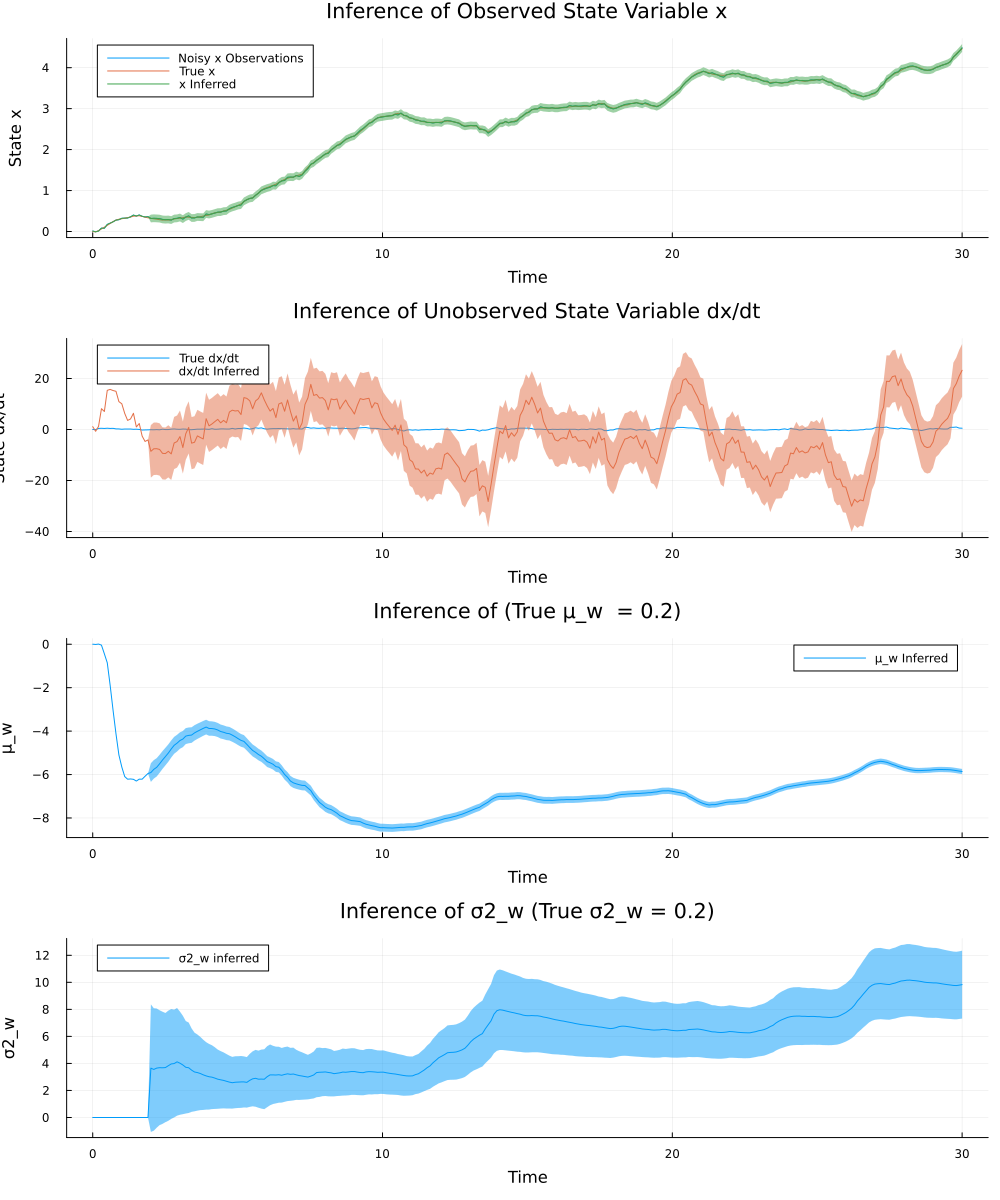

In [22]:
include("Julia_Implementation.jl")
using Random
using Distributions
using LinearAlgebra
using Statistics
using StatsFuns: logsumexp
using .Threads
using ProgressMeter
using SpecialFunctions
using Plots
using DataFrames
#Generating the noisy observations

# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 1000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -2.0
kw = 1.0
kv = 0.001
true_sigmaw2 = 0.2
true_sigmaw = sqrt(true_sigmaw2)
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 10.0
T = 30.0
N = 10 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0 ; 1.0]
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")

subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 1000)# subordinator jump sizes and times
SDE_samples = Julia_Implementation.generate_SDE_samples(subordinator_jumps[1,:],jump_times[1,:],true_muw,true_sigmaw,A,h,evaluation_points)
#print(size(samples))
Noisy_samples = SDE_samples[1, :] .+ randn(length(SDE_samples[1, :])) .* sigma_n




alphaw_prior = 0.001
betaw_prior = 0.001
#Pre-heating
Julia_Implementation.Normal_Gamma_Langevin_MPF(Noisy_samples,N,T,2,true_theta,true_beta,true_C,kw,alphaw_prior,betaw_prior,kv)
#Serious Run
inferred_Xs, inferred_covs, sigmaw2_means, sigmaw2_uncertaintys, accumulated_Es, accumulated_Fs, accumulated_log_marginals = Julia_Implementation.Normal_Gamma_Langevin_MPF(Noisy_samples,N,T,num_particles,100,true_beta,true_C,kw,alphaw_prior,betaw_prior,kv)



#Processing Results and Visualisation 
skip_num = 20
state_xs = [vec[1] for vec in inferred_Xs]
state_dxdts = [vec[2] for vec in inferred_Xs]
state_muws = [vec[3] for vec in inferred_Xs]
sigmaw2_means[1:skip_num] = zeros(skip_num)

state_x_vars = [cov[1,1] for cov in inferred_covs]
state_dxdt_vars = [cov[2,2] for cov in inferred_covs]
state_muw_vars = [cov[3,3] for cov in inferred_covs]
state_x_vars[1:skip_num] = zeros(skip_num)
state_dxdt_vars[1:skip_num] = zeros(skip_num)
state_muw_vars[1:skip_num] = zeros(skip_num)
sigmaw2_uncertaintys[1:skip_num] = zeros(skip_num)

state_x_stds = sqrt.(state_x_vars)
state_dxdt_stds = sqrt.(state_dxdt_vars)
state_muw_stds = sqrt.(state_muw_vars)
sigmaw2_stds = sqrt.(sigmaw2_uncertaintys)

# x plt
p1 = plot(evaluation_points, Noisy_samples, label="Noisy x Observations", title="Inference of Observed State Variable x", xlabel="Time", ylabel="State x")
plot!(evaluation_points, SDE_samples[1, :], label="True x")
plot!(evaluation_points, state_xs, ribbon=state_x_stds.*3, label="x Inferred")
# dxdt plot
p2 = plot(evaluation_points, SDE_samples[2,:], label="True dx/dt", title="Inference of Unobserved State Variable dx/dt", xlabel="Time", ylabel="State dx/dt")
plot!(evaluation_points, state_dxdts, ribbon=state_dxdt_stds.*3, label="dx/dt Inferred")
#plot!(evaluation_points, state_dxdts, label="dx/dt Inferred")

#muw plot
p3 = plot(evaluation_points, state_muws,ribbon = state_muw_stds, label="μ_w Inferred", title="Inference of (True μ_w  = $(true_muw))", xlabel="Time", ylabel="μ_w")


#sigmaw plot
p4 = plot(evaluation_points,sigmaw2_means,ribbon = sigmaw2_stds .*3, label = "σ2_w inferred",title = "Inference of σ2_w (True σ2_w = $(true_sigmaw2))",xlabel="Time", ylabel="σ2_w")

plot(p1,p2,p3,p4, layout = (4,1),size = (1000,1200))

### Particle MCMC Implementation

In [2]:
include("Julia_Implementation.jl")
using Random
using Distributions
using LinearAlgebra
using Statistics
using StatsFuns: logsumexp
using .Threads
using ProgressMeter
using SpecialFunctions
using Plots
using DataFrames
#Generating the noisy observations

# 参数初始化
num_iter = 3000 # 迭代次数
num_particles = 1000


# 三个参数的步长
l_theta = 0.5
l_beta = 0.0
l_C = 0.0
# 参数priors
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测

# 真实参数值
true_theta = -1.0
true_beta = 5.0
true_C = 2.0


kw = 1.0
kv = 0.001
true_sigmaw2 = 0.2
true_sigmaw = sqrt(true_sigmaw2)
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
T = 30.0
N = 10 * round(Int,T) # resolution

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0 ; 1.0]
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")

subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 10000)# subordinator jump sizes and times
SDE_samples = Julia_Implementation.generate_SDE_samples(subordinator_jumps[1,:],jump_times[1,:],true_muw,true_sigmaw,A,h,evaluation_points)
#print(size(samples))
Noisy_samples = SDE_samples[1, :] .+ randn(length(SDE_samples[1, :])) .* sigma_n




alphaw_prior = 0.001
betaw_prior = 0.001

# Pre-heating Run
Julia_Implementation.Normal_Gamma_Langevin_GRW_MCMC(Noisy_samples,N,T,10,10,kw ,alphaw_prior,betaw_prior,kv, theta0, beta0, C0, l_theta,l_beta,l_C)


#Serious Run
theta_samples, beta_samples, C_samples = Julia_Implementation.Normal_Gamma_Langevin_GRW_MCMC(Noisy_samples,N,T,num_particles,num_iter,kw ,alphaw_prior,betaw_prior,kv, theta0, beta0, C0, l_theta,l_beta,l_C)


p1 = Julia_Implementation.plot_samples_distribution(theta_samples, true_theta, "Theta Distribution")
p2 = Julia_Implementation.plot_samples_distribution(beta_samples, true_beta, "Beta Distribution")
p3 = Julia_Implementation.plot_samples_distribution(C_samples, true_C, "C Distribution")

# Combine the plots
plot(p1, p2, p3, layout=(3, 1), size=(600, 1200))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:31:35


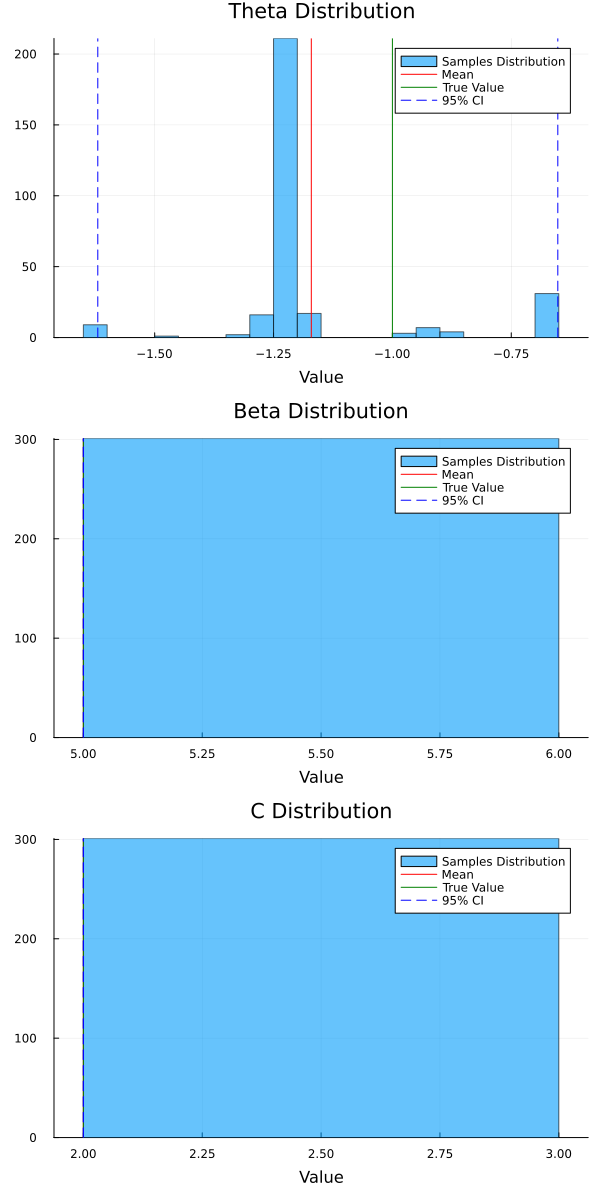

In [1]:

include("Julia_Implementation.jl")
using Random
using Distributions
using LinearAlgebra
using Statistics
using StatsFuns: logsumexp
using .Threads
using ProgressMeter
using SpecialFunctions
using Plots
using DataFrames
#Generating the noisy observations

# 参数初始化
num_iter = 300 # 迭代次数
num_particles = 1000


# 三个参数的步长
l_theta = 0.5
l_beta = 0.0
l_C = 0.0
# 参数priors
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测

# 真实参数值
true_theta = -1.0
true_beta = 5.0
true_C = 2.0


kw = 1.0
kv = 0.001
true_sigmaw2 = 0.2
true_sigmaw = sqrt(true_sigmaw2)
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
T = 30.0
N = 10 * round(Int,T) # resolution

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0 ; 1.0]
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")

subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 10000)# subordinator jump sizes and times
SDE_samples = Julia_Implementation.generate_SDE_samples(subordinator_jumps[1,:],jump_times[1,:],true_muw,true_sigmaw,A,h,evaluation_points)
#print(size(samples))
Noisy_samples = SDE_samples[1, :] .+ randn(length(SDE_samples[1, :])) .* sigma_n




alphaw_prior = 0.001
betaw_prior = 0.001

# Pre-heating Run
Julia_Implementation.Normal_Gamma_Langevin_GRW_MCMC(Noisy_samples,N,T,10,10,kw ,alphaw_prior,betaw_prior,kv, theta0, beta0, C0, l_theta,l_beta,l_C)


#Serious Run
theta_samples, beta_samples, C_samples = Julia_Implementation.Normal_Gamma_Langevin_GRW_MCMC(Noisy_samples,N,T,num_particles,num_iter,kw ,alphaw_prior,betaw_prior,kv, theta0, beta0, C0, l_theta,l_beta,l_C)


p1 = Julia_Implementation.plot_samples_distribution(theta_samples, true_theta, "Theta Distribution")
p2 = Julia_Implementation.plot_samples_distribution(beta_samples, true_beta, "Beta Distribution")
p3 = Julia_Implementation.plot_samples_distribution(C_samples, true_C, "C Distribution")

# Combine the plots
plot(p1, p2, p3, layout=(3, 1), size=(600, 1200))


In [19]:
using Random
using Distributions
using LinearAlgebra
using Statistics
using StatsFuns: logsumexp
using .Threads
using ProgressMeter
using SpecialFunctions
using StatsBase
using Plots
x = [1 2 3 4 5]
probs = ones(5)./5
indices = sample(1:5, Weights(probs), 5; replace=true)
print(x[indices])

[3, 2, 1, 5, 3]